In [172]:
import requests
import numpy as np
import pandas as pd
import math
import aiohttp
import httpx
import asyncio
import ujson as json
from datetime import datetime
import time
import os
import sys
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import List, Optional, Dict, TypeAlias
JSON: TypeAlias = dict[str, "JSON"] | list["JSON"] | str | int | float | bool | None

from dotenv import load_dotenv
load_dotenv()

from CUSIP_Curve import CUSIP_Curve
from CurveInterpolator import CurveInterpolator

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def temp_tester_httpx(start, end, cusips):
    async def build_tasks(client: httpx.AsyncClient, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(client=client, cusips=cusips, start_date=start, end_date=end)
        return await asyncio.gather(*tasks)
    
    async def run_fetch_all(start, end, cusips):
        async with httpx.AsyncClient() as client:
            all_data = await build_tasks(client=client, cusips=cusips, start=start, end=end)
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

def temp_tester_aio(start, end, cusips):
    async def build_tasks(session: aiohttp.ClientSession, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(session=session, cusips=cusips, start_date=start, end_date=end)
        return await asyncio.gather(*tasks)
    
    async def run_fetch_all(start, end, cusips):
        async with aiohttp.ClientSession() as session:
            all_data = await build_tasks(session=session, cusips=cusips, start=start, end=end)
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

In [ ]:
# CUSIP_Curve(debug_verbose=True).fetch_historcal_trace_trade_history_by_cusip(
#     cusips=["912810UA4"],
#     start_date=datetime(2024, 7, 29),
#     end_date=datetime(2024, 8, 2),
#     # xlsx_path="trace_trade_history_may54s.xlsx",
# )

In [36]:
as_of_date = datetime(2024, 8, 15)
cusip_curve_builder = CUSIP_Curve(no_logs_plz=True, use_ust_issue_date=True)
auctions_df = cusip_curve_builder.get_auctions_df(as_of_date=as_of_date)

In [37]:
df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    calc_ytms=True,
    # use_quantlib=True,
    # include_auction_results=True,
    # include_soma_holdings=True,
    # include_stripping_activity=True,
    auctions_df=auctions_df,
    sorted=True,
)
df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,original_security_term,offer_price,bid_price,eod_price,mid_price,offer_yield,bid_yield,eod_yield,mid_yield
0,912797KY2,Bill,2024-04-17,2024-04-23,2024-08-20,0.013699,NaN,5.406000,False,Aug 24s,17-Week,0.000000,99.927222,99.941778,49.963611,NaN,6.736164,5.370588,NaN
1,912797KZ9,Bill,2024-04-24,2024-04-30,2024-08-27,0.032877,NaN,5.406000,False,Aug 24s,17-Week,99.825333,99.825000,99.839889,99.825166,5.869420,5.880783,5.373380,5.875101
2,912797LA3,Bill,2024-05-01,2024-05-07,2024-09-03,0.052055,NaN,5.412000,False,Sep 24s,17-Week,99.724236,99.723972,99.738500,99.724104,5.726068,5.731635,5.425511,5.728851
3,912797LG0,Bill,2024-05-08,2024-05-14,2024-09-10,0.071233,NaN,5.406000,False,Sep 24s,17-Week,99.621917,99.621556,99.636111,99.621736,5.654384,5.659869,5.438854,5.657127
4,912797LH8,Bill,2024-05-15,2024-05-21,2024-09-17,0.090411,NaN,5.401000,False,Sep 24s,17-Week,99.519667,99.518750,99.535111,99.519208,5.614501,5.625395,5.431124,5.619948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,912810TV0,Bond,2023-11-09,2023-11-15,2053-11-15,29.271233,4.750,NaN,False,Nov 53s,30-Year,109.328125,109.312500,109.656250,109.320312,4.193092,4.193967,4.174757,4.193530
395,912810TX6,Bond,2024-02-08,2024-02-15,2054-02-15,29.523288,4.250,NaN,False,Feb 54s,30-Year,100.734375,100.718750,101.031250,100.726562,4.206280,4.207205,4.188744,4.206742
396,912810TX6,Bond,2024-03-13,2024-03-15,2054-02-15,29.523288,4.250,NaN,False,Feb 54s,30-Year,100.734375,100.718750,101.031250,100.726562,4.206280,4.207205,4.188744,4.206742
397,912810UA4,Bond,2024-05-09,2024-05-15,2054-05-15,29.767123,4.625,NaN,False,May 54s,30-Year,107.234375,107.218750,107.500000,107.226562,4.196562,4.197442,4.181633,4.197002


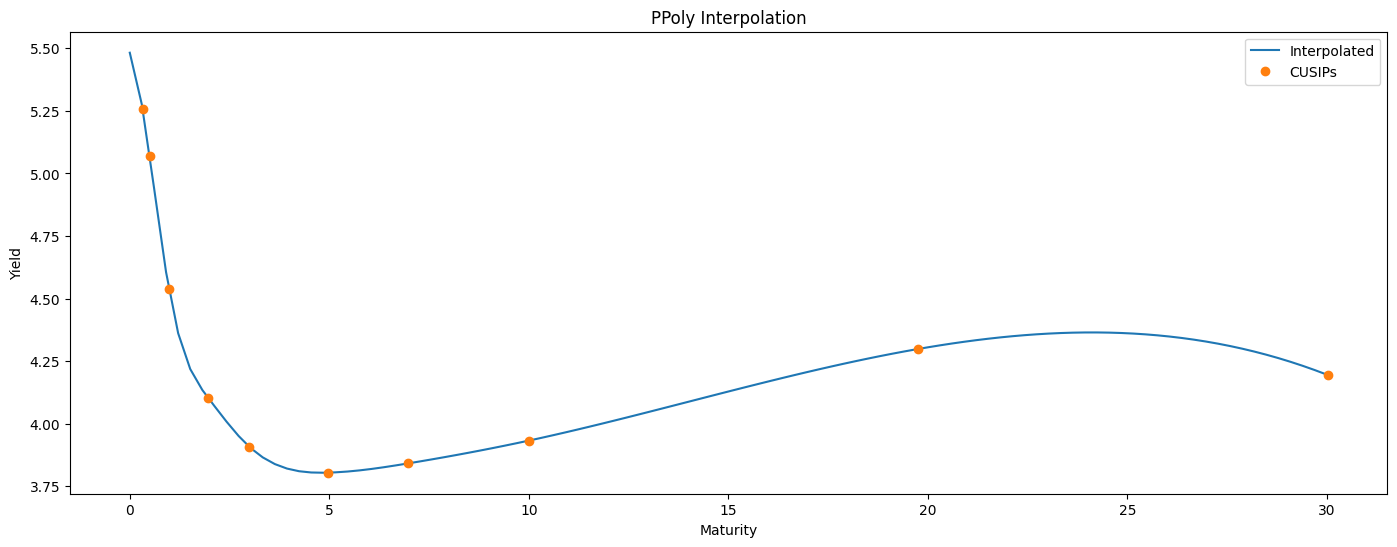

In [174]:
interpolator = CurveInterpolator(
    curve_set_df=df[df["is_on_the_run"] == True],
    linspace_x_num=100,
    enable_extrapolate_left_fill=True,
    enable_extrapolate_right_fill=True,
    use_bid_side=True
)

# interpolator.set_cubic_spline_interpolation_bc_type(bc_type="natural")
# interpolator.set_cubic_spline_interpolation_custom_knots(custom_knots=np.array([15, 17, 22]))
# interpolator.set_cubic_spline_interpolation_nu(nu=0)
interpolator.set_b_spline_k(2)
interpolator.plotter(
    # linear=True, 
    # log_linear=True, 
    # cubic=True,
    # cubic_hermite=True, 
    # pchip=True, 
    # akima=True,
    # b_spline=True,
    ppoly=True,
    # run_parallel=True,
    # cubic_bc_types_n_knots_n_nu=[("natural", np.array([]), 0)]
)

In [110]:
import matplotlib.pyplot as plt
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_bc_ols,
    calibrate_bc_augmented_ols,
    calibrate_diebold_li_ols,
    calibrate_mles_ols,
    calibrate_smith_wilson_ols,
)
from models.MonotoneConvex import MonotoneConvex

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


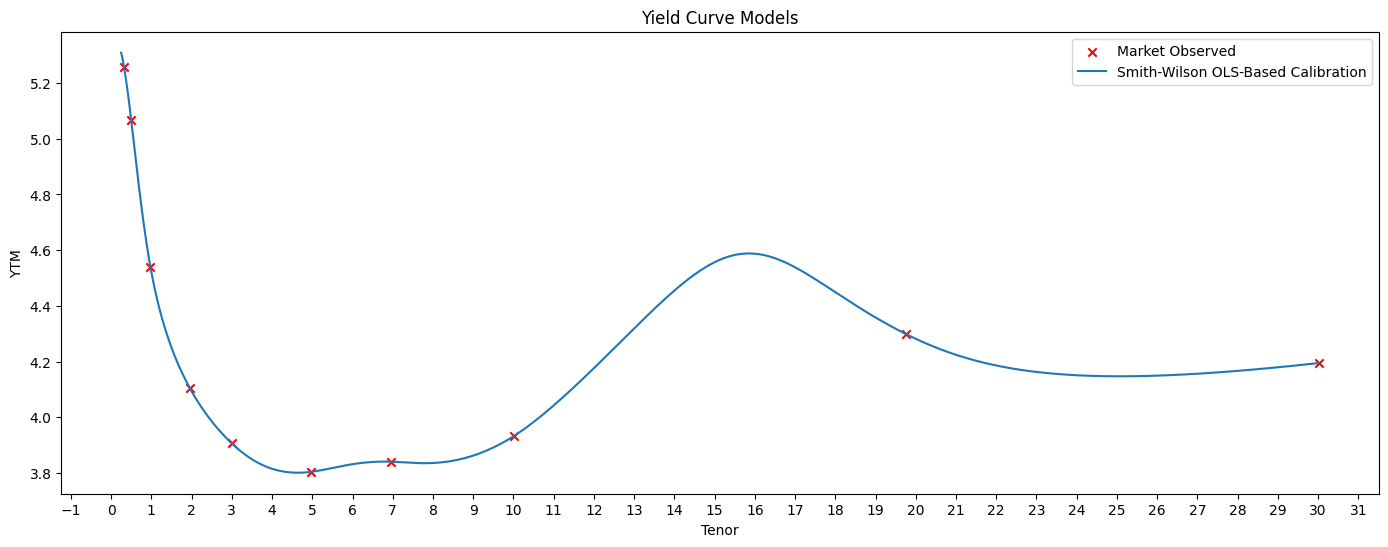

In [189]:
maturities = np.array(
    [
        0.32054794520547947,
        0.4986301369863014,
        0.9780821917808219,
        1.9589041095890412,
        3.0,
        4.961643835616439,
        6.961643835616439,
        10.005479452054795,
        19.76164383561644,
        30.019178082191782,
    ]
)

yields = np.array(
    [
        5.258047907623223,
        5.068313806703524,
        4.538977465708812,
        4.104248469556026,
        3.906360694376456,
        3.8039494327325727,
        3.8405160868389356,
        3.9321489548631066,
        4.298374133968205,
        4.1947433231346425,
    ]
)

curve_ns, status_ns = calibrate_ns_ols(
    maturities,
    yields,
    tau0=1.0,
)
assert status_ns.success

curve_nss, status_nss = calibrate_nss_ols(
    maturities,
    yields,
)
assert status_nss.success

curve_bc, status_bc = calibrate_bc_ols(maturities, yields)
assert status_bc.success

curve_bca, status_bca = calibrate_bc_augmented_ols(maturities, yields)
assert status_bca.success

curve_di, status_di = calibrate_diebold_li_ols(maturities, yields)
assert status_di.success

curve_mlesm, status_mlesm = calibrate_mles_ols(maturities, yields, overnight_rate=5.34)
# assert status_mlesm.success

ufr = None
curve_sw, status_sw = calibrate_smith_wilson_ols(maturities, yields, ufr=ufr, overnight_rate=5.34)
assert status_sw.success

t2 = np.linspace(0.25, 30, 1000)
plt.figure(figsize=(17, 6))
plt.scatter(
    maturities,
    yields,
    marker="x",
    color="red",
    label="Market Observed",
)
# plt.plot(t2, curve_ns(t2), "b-", label="NS OLS-Based-Calibration")
# plt.plot(t2, curve_nss(t2), "g-", label="NSS OLS-Based-Calibration")
# plt.plot(t2, curve_bc(t2), label="Bjork-Christensen OLS-Based Calibration")
# plt.plot(t2, [mc.spot(t) for t in t2], label="mc")
# plt.plot(t2, curve_bca(t2), label="Bjork-Christensen-Augmented OLS-Based Calibration")
# plt.plot(t2, curve_di(t2), label="Diebold-Li OLS-Based Calibration")
# plt.plot(t2, curve_mlesm(t2), label="MLESM OLS-Based Calibration")
plt.plot(t2, curve_sw(t2), label="Smith-Wilson OLS-Based Calibration")

plt.title("Yield Curve Models")
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.legend()
plt.show()